# SVM

***

[Simulador Interativo](https://greitemann.dev/svm-demo)

Varie:
- kernel
- $C$ (que controla a rigidez da margem)
- gamma (que controla o tamanho da função)

## Importando bibliotecas

In [1]:
pip install ucimlrepo

In [2]:
# Bibliotecas de manipualção e visualização de dados
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions

#Repositorio de datasets
from ucimlrepo import fetch_ucirepo

# Classes do modelo
from sklearn.svm import SVC

# Funções de avaliação dos modelos
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

## Métodos para visualização

In [3]:
# Extraído de https://jakevdp.github.io/PythonDataScienceHandbook/05.07-support-vector-machines.html
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)

    # plot decision boundary and margins
    ax.contour(
        X,
        Y,
        P,
        colors='k',
        levels=[-1, 0, 1],
        alpha=0.5,
        linestyles=['--', '-', '--']
    )

    # plot support vectors
    if plot_support:
        ax.scatter(
            model.support_vectors_[:, 0],
            model.support_vectors_[:, 1],
            s=300,
            linewidth=1,
            facecolors='none'
        )

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

In [4]:
def show_decision_region(X, y, model):
    X = pd.DataFrame(X)
    y = pd.DataFrame(y)

    feature_0 = X.columns[0]
    feature_1 = X.columns[1]

    plot_decision_regions(np.array([X[feature_0].values,
                                    X[feature_1].values]).T,
                                    y.values.flatten(), model)
    plt.xlabel(feature_0)
    plt.ylabel(feature_1)

    plt.title(model.__class__.__name__)
    plt.show()

In [5]:
def plot_dataset(X, y, ax=None):
    X = np.array(X)
    y = np.array(y)

    # cores e simbolos para as classses
    colors = {0: "steelblue", 1: "darkorange", 2: "mediumseagreen"}
    markers = {0: "s", 1: "^", 2:"o"}

    if ax is None:
        plt.scatter(X[y==0, 0],X[y==0, 1], c=colors[0], marker=markers[0])
        plt.scatter(X[y==1, 0],  X[y==1, 1], c=colors[1], marker=markers[1])
    else:
        ax.scatter(X[y==0, 0],X[y==0, 1], c=colors[0], marker=markers[0])
        ax.scatter(X[y==1, 0],  X[y==1, 1], c=colors[1], marker=markers[1])


## conjunto de dados

In [6]:
# fetch dataset
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17)

# data (as pandas dataframes)
X = breast_cancer_wisconsin_diagnostic.data.features
y = breast_cancer_wisconsin_diagnostic.data.targets

dataset = pd.concat([X,y], axis=1)
dataset

dataset['Diagnosis'] = pd.factorize(dataset['Diagnosis'])[0]
dataset.head()

# Maligno - 0
# Benigno - 1
# 569 rows × 31 columns

,radius1,texture1,perimeter1,area1,smoothness1,compactness1,concavity1,concave_points1,symmetry1,fractal_dimension1,...,texture3,perimeter3,area3,smoothness3,compactness3,concavity3,concave_points3,symmetry3,fractal_dimension3,Diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [7]:
dataset.describe()

,radius1,texture1,perimeter1,area1,smoothness1,compactness1,concavity1,concave_points1,symmetry1,fractal_dimension1,...,texture3,perimeter3,area3,smoothness3,compactness3,concavity3,concave_points3,symmetry3,fractal_dimension3,Diagnosis
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,0.627417
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,0.483918
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,0.000000
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,0.000000
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,1.000000
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,1.000000
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,1.000000


In [8]:
dataset['Diagnosis'].value_counts()

,count
Diagnosis,
1,357
0,212


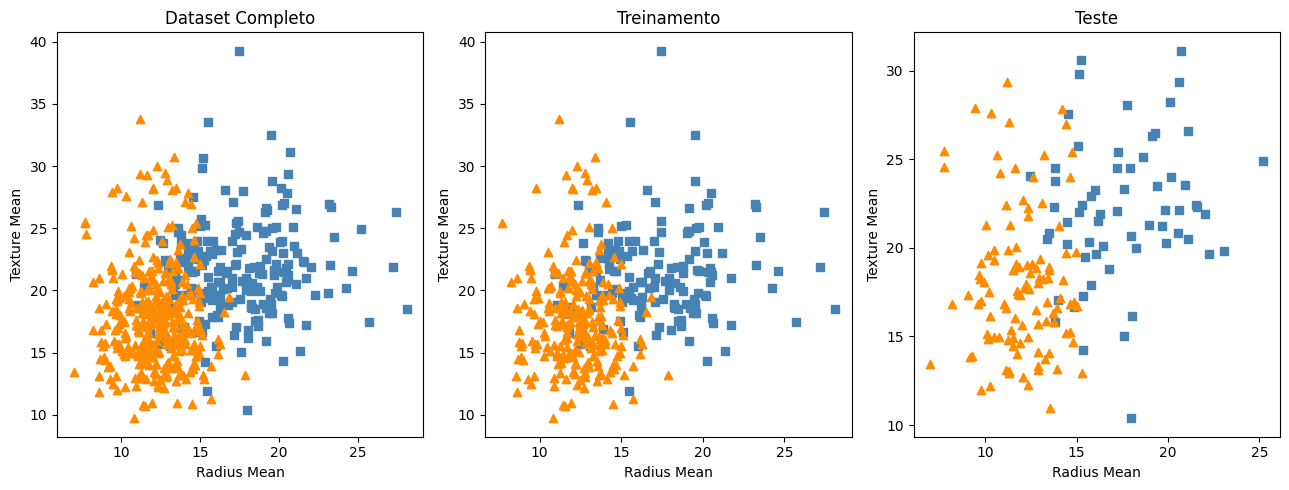

In [9]:
X = dataset[['radius1', 'texture1']]
y = dataset['Diagnosis']

seed = 42

#Separando o conjunto de dados em treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

fig, ax = plt.subplots(1,3, figsize=(13,5))

plot_dataset(X, y, ax=ax[0])
ax[0].set_title('Dataset Completo')
ax[0].set_xlabel('Radius Mean')
ax[0].set_ylabel('Texture Mean')

# Plota o conjunto de treinamento
plot_dataset(X_train, y_train, ax=ax[1])
ax[1].set_title('Treinamento')
ax[1].set_xlabel('Radius Mean')
ax[1].set_ylabel('Texture Mean')

# Plota o conjunto de teste
plot_dataset(X_test, y_test, ax=ax[2])
ax[2].set_title('Teste')
ax[2].set_xlabel('Radius Mean')
ax[2].set_ylabel('Texture Mean')

plt.tight_layout()
plt.show()

## Treinamento do modelo

A margem é a característica mais importante do SVM, ao invés de criar apenas uma linha separando duas classes, podemos usar uma margem. A margem é a distâncie entre a reta de classificação e as instâncias mais próximas de cada classe. Utilizando uma instância de cada classe como vetor de suporte, o algoritmo maximiza a margem entre esses dois vetores.

Vamos utilizar uma das implementações do SVM no _sklearn_, o [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html).

Alguns prânmetros do modelo:

**C**: default = $1.0$. Penalização por instância errada (_C_), quanto maior a penalização, menos instâncias devem estar presentes dentro da margem e menor deverá ser a distância entre os vetores de suporte.

**kernel**: {‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’} or callable, default=’rbf’.

Cada kernel possui um conjunto de hiperparâmetros específicos:

- _linear_ $: \langle x, x'\rangle $
- _poly_ (polinomial) $(\gamma \langle x, x' \rangle + r)^d$: parametros _gamma_ ($\gamma$), _degree_ ($d$), _coef0_ ($r$)
- _rbf_ (Radial Basis Function) $exp(-\gamma ||x-x'||^2)$: parametros _gamma_ ($\gamma$)
- _sigmoid_ (sigmóide) $tanh(\gamma \langle x, x' \rangle + r)$: parametros _gamma_ ($\gamma$), _coef0_ ($r$)

[Para mais insformações](https://scikit-learn.org/stable/modules/svm.html#svm-kernels)

Vamos considerar por hora o kernel linear.



              precision    recall  f1-score   support

           0       0.91      0.83      0.87        63
           1       0.90      0.95      0.93       108

    accuracy                           0.91       171
   macro avg       0.91      0.89      0.90       171
weighted avg       0.91      0.91      0.91       171



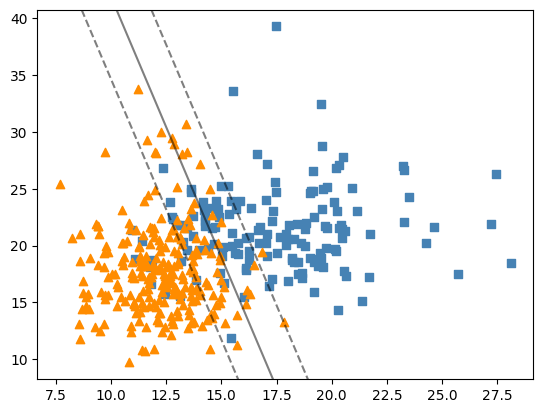

In [10]:
model = SVC(kernel="linear", random_state=seed)
model.fit(X_train, y_train)

plot_dataset(X_train, y_train)
plot_svc_decision_function(model)

print(classification_report(y_test, model.predict(X_test)))

## Ajustando alguns parâmetros

In [11]:
model = SVC(random_state=seed)

parameters = {
    'C': [1, 100, 1000, 10000],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid']
    # gamma: Kernel coefficient, controla a largura da função
    # decision_function_shape: 'ovo', 'ovr'
    # default='ovr' (one-vs-rest)
}

grid = GridSearchCV(estimator=model,
    param_grid=parameters,
    scoring='accuracy',
    cv=5,
    return_train_score=True)

grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)

# Acurácia de cada combinação
results = pd.DataFrame(grid.cv_results_)
print("Acurácia de cada combinação de parâmetros:")
print(results[['params', 'mean_test_score', 'std_test_score']])

# Melhor parâmetro
print("\nMelhor parâmetro:", grid.best_params_)
print("Melhor acurácia:", grid.best_score_)


print(classification_report(y_test, y_pred))

Acurácia de cada combinação de parâmetros:
                               params  mean_test_score  std_test_score
0        {'C': 1, 'kernel': 'linear'}         0.879209        0.038398
1           {'C': 1, 'kernel': 'rbf'}         0.899335        0.035953
2          {'C': 1, 'kernel': 'poly'}         0.901804        0.045003
3       {'C': 1, 'kernel': 'sigmoid'}         0.625633        0.004077
4      {'C': 100, 'kernel': 'linear'}         0.876709        0.038993
5         {'C': 100, 'kernel': 'rbf'}         0.884209        0.042179
6        {'C': 100, 'kernel': 'poly'}         0.896772        0.044986
7     {'C': 100, 'kernel': 'sigmoid'}         0.625633        0.004077
8     {'C': 1000, 'kernel': 'linear'}         0.876709        0.037355
9        {'C': 1000, 'kernel': 'rbf'}         0.884241        0.044222
10      {'C': 1000, 'kernel': 'poly'}         0.884209        0.042179
11   {'C': 1000, 'kernel': 'sigmoid'}         0.625633        0.004077
12   {'C': 10000, 'kernel': 'linea

**Vamos visualizar como esses parâmetros se comportam**


A medida em que a penalização aumenta, os vetores de suporte serão as instâncias mais próximos da fronteira.

C =  1


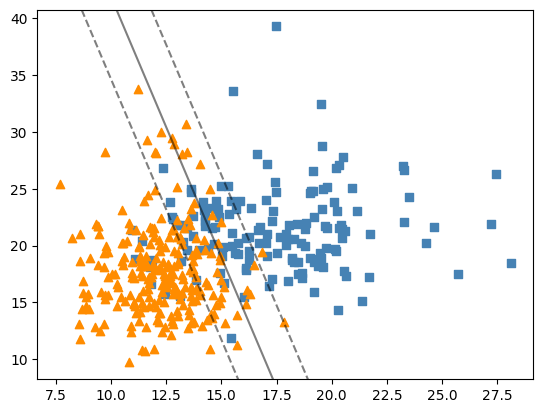

C =  100


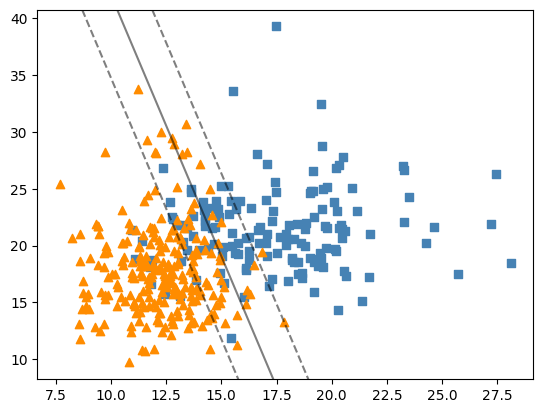

C =  1000


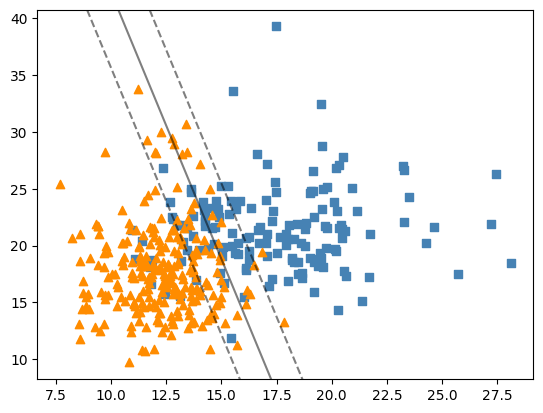

C =  10000


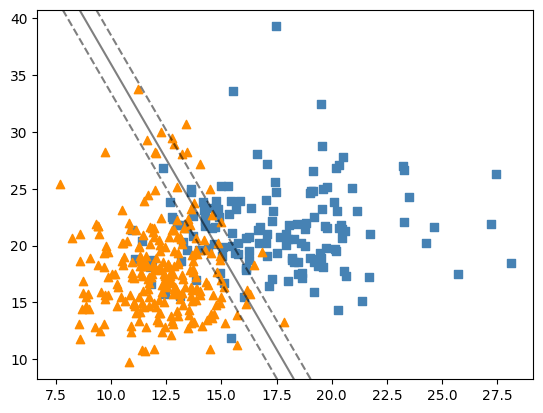

In [12]:
X = dataset[['radius1', 'texture1']]
y = dataset['Diagnosis']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

for C in [1, 100, 1000, 10000]:
    plt.figure()
    print("C = ", C)
    model = SVC(C=C, kernel="linear")
    model.fit(X_train, y_train)

    plot_dataset(X_train, y_train)
    plot_svc_decision_function(model)
    plt.show()

C =  1


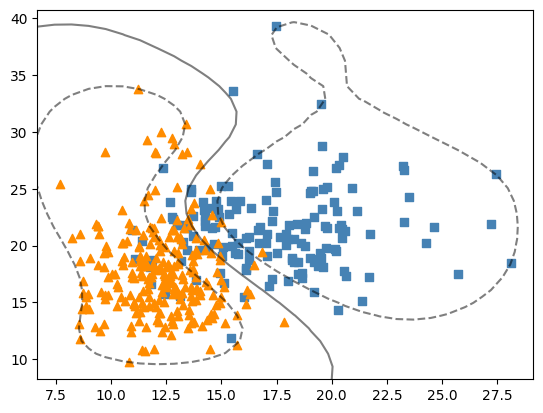

C =  100


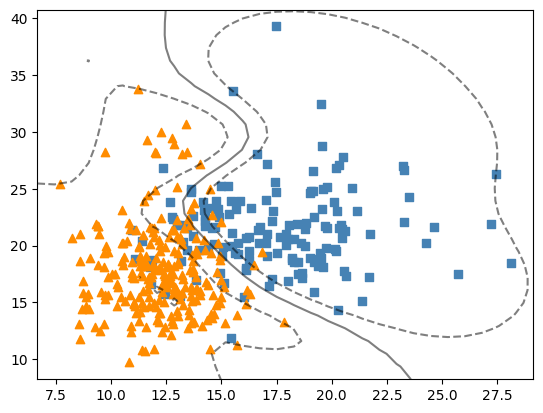

C =  1000


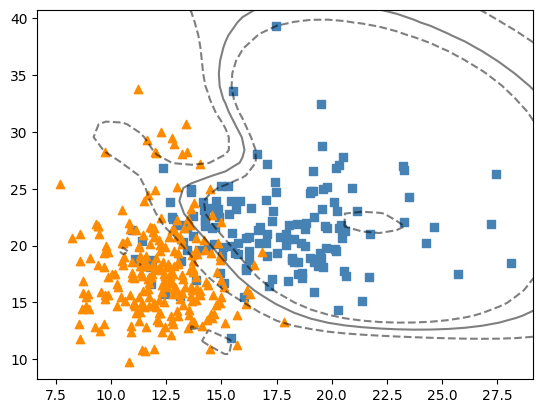

C =  10000


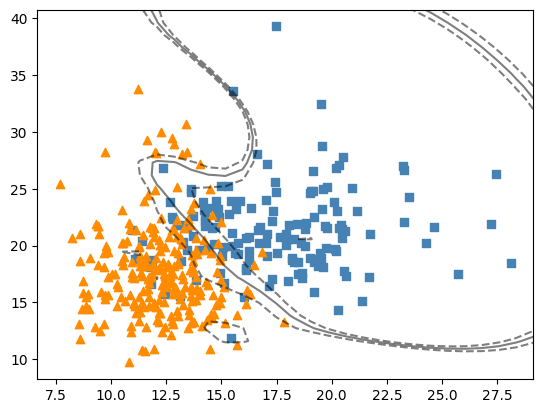

In [13]:
X = dataset[['radius1', 'texture1']]
y = dataset['Diagnosis']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

for C in [1, 100, 1000, 10000]:
    plt.figure()
    print("C = ", C)
    model = SVC(C=C, kernel="rbf")
    model.fit(X_train, y_train)

    plot_dataset(X_train, y_train)
    plot_svc_decision_function(model)
    plt.show()

## Usando todas as features do datasets

In [22]:
svm_model = SVC(random_state=seed)

X = breast_cancer_wisconsin_diagnostic.data.features
y = breast_cancer_wisconsin_diagnostic.data.targets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

parameters = {
    'C': [1, 100, 1000, 10000],
    'kernel': ['linear', 'rbf', 'poly']
}

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

grid = GridSearchCV(estimator=svm_model,
    param_grid=parameters,
    scoring='accuracy',
    cv=kf,
    return_train_score=True)

grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)

# Acurácia de cada combinação
results = pd.DataFrame(grid.cv_results_)
print("Acurácia de cada combinação de parâmetros:")
print(results[['params', 'mean_test_score', 'std_test_score']])

# Melhor parâmetro
print("\nMelhor parâmetro:", grid.best_params_)
print("Melhor acurácia:", grid.best_score_)


print(classification_report(y_test, y_pred))

Acurácia de cada combinação de parâmetros:
                              params  mean_test_score  std_test_score
0       {'C': 1, 'kernel': 'linear'}         0.949747        0.011256
1          {'C': 1, 'kernel': 'rbf'}         0.902120        0.028674
2         {'C': 1, 'kernel': 'poly'}         0.899589        0.025937
3     {'C': 100, 'kernel': 'linear'}         0.947247        0.009377
4        {'C': 100, 'kernel': 'rbf'}         0.917310        0.039786
5       {'C': 100, 'kernel': 'poly'}         0.914810        0.043382
6    {'C': 1000, 'kernel': 'linear'}         0.937247        0.010898
7       {'C': 1000, 'kernel': 'rbf'}         0.937310        0.030568
8      {'C': 1000, 'kernel': 'poly'}         0.917215        0.037433
9   {'C': 10000, 'kernel': 'linear'}         0.937247        0.010898
10     {'C': 10000, 'kernel': 'rbf'}         0.949778        0.021089
11    {'C': 10000, 'kernel': 'poly'}         0.937278        0.023619

Melhor parâmetro: {'C': 10000, 'kernel': 'rbf'

## Avaliando outros datasets

Agora, vamos observar como o SVM se comporta outro dataset.

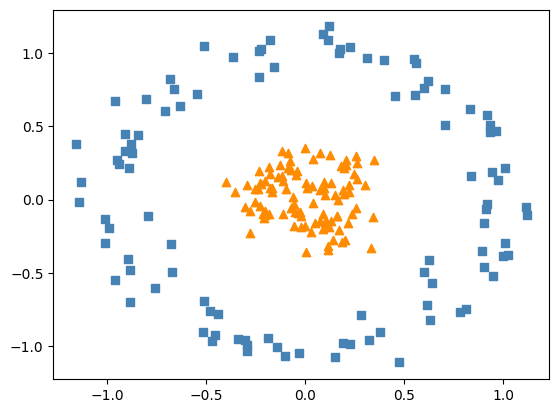

In [15]:
from sklearn.datasets import make_circles

# criação do dataset
X, y = make_circles(n_samples=200, noise=0.1, random_state=seed, factor=0.2)

plot_dataset(X, y)

In [16]:
#Separando o conjunto de dados em treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

Como o SVM com kernel linear se comporta nesse problema?

              precision    recall  f1-score   support

           0       1.00      0.28      0.44        32
           1       0.55      1.00      0.71        28

    accuracy                           0.62        60
   macro avg       0.77      0.64      0.57        60
weighted avg       0.79      0.62      0.56        60



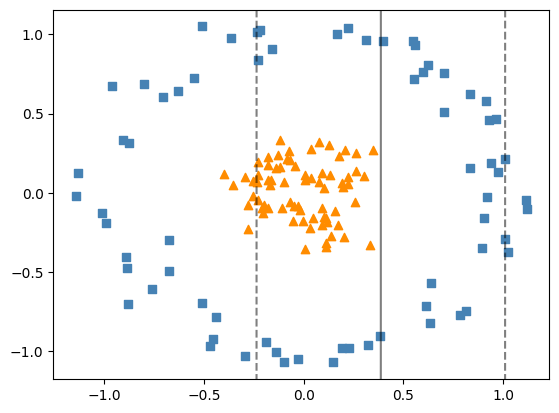

In [17]:
model = SVC(C=10, kernel="linear")
model.fit(X_train, y_train)
print(classification_report(y_test, model.predict(X_test)))

plot_dataset(X_train, y_train)
plot_svc_decision_function(model)

Visualizando a região de decisão

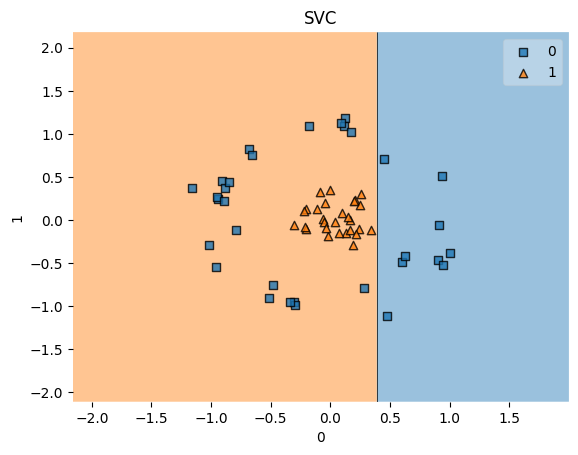

In [18]:
show_decision_region(X_test,y_test, model)

Como podemos observar, a região do problema não é linearmente separável. O SVM tenta criar uma nova dimensão e tenta transformar o problema em um problema linearmente separável com essa nova dimensão. Assim, cada problema requer uma análise sobre qual _kernel_ deve ser utilizado.

Para esse problema, vamos usar o _kernel_ _rbf_ como transformação para os dados.

Assim, vamos criar um classificador SVM que utiliza esse kernel e observar a região de decisão no espaço original.

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        32
           1       1.00      1.00      1.00        28

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60



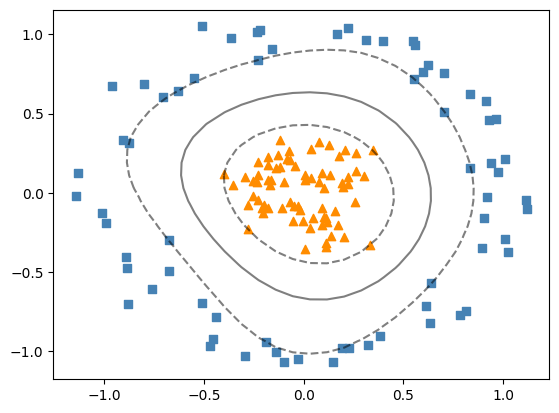

In [19]:
model = SVC(C=10, kernel="rbf")
model.fit(X_train, y_train)
print(classification_report(y_test, model.predict(X_test)))

plot_dataset(X_train, y_train)

plot_svc_decision_function(model)

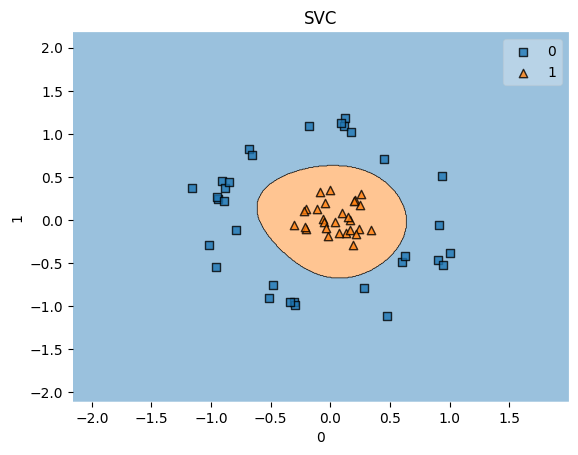

In [20]:
show_decision_region(X_test,y_test,model)

[Example: Face Recognition](https://jakevdp.github.io/PythonDataScienceHandbook/05.07-support-vector-machines.html)